In [ ]:
# !pip install scikit-learn
# !pip install pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# Defined parameters and file paths
# ==========================================
eeg_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta':  (13, 30),
    'gamma': (30, 45)
}
fs = 250  # sampling rate (Hz)

train_dir = 'Data/'
test_dir  = 'Data/'


def apply_CAR(data):
    """
    Subtracts the mean across all channels at each time point.
    data: ndarray (n_trials, n_samples, n_channels)
    """
    mean_chan = data.mean(axis=2, keepdims=True)
    return data - mean_chan


In [2]:
def compute_band_powers( freqs, power_spec, bands):
    """Compute mean power in each frequency band."""
    bp = {}
    for band, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs < high))[0]
        bp[band] = power_spec[idx].mean() if idx.size else 0.0
    return bp


def extract_single_band_channel(data_car, freqs, bands, channel, band):
    """
    Extract 1-D features: power of one band on one channel per trial.
    Returns X (n_trials,1).
    """
    n_trials = data_car.shape[0]
    X = np.zeros((n_trials, 1))
    for t in range(n_trials):
        sig = data_car[t,:,channel]
        P = np.abs(np.fft.rfft(sig))**2 #get power spectrum
        bp = compute_band_powers( freqs, P, {band: bands[band]})
        X[t,0] = bp[band]
    return X

In [3]:
def extract_all_bands_channel(data_car, freqs, bands, channel):
    """
    Extract 5-D features: all band powers on one channel per trial.
    Returns X (n_trials, 5).
    """
    n_trials = data_car.shape[0]
    X = np.zeros((n_trials, len(bands)))
    sorted_bands = sorted(bands)
    for t in range(n_trials):
        sig = data_car[t,:,channel]
        P = np.abs(np.fft.rfft(sig))**2
        bp = compute_band_powers(freqs, P, bands)
        X[t,:] = [bp[b] for b in sorted_bands]
    return X

In [4]:
def extract_band_all_channels(data_car, freqs, bands, band):
    """
    Extract multi-channel features for a single band per trial.
    Returns X (n_trials, n_channels).
    """
    n_trials, _, n_ch = data_car.shape
    X = np.zeros((n_trials, n_ch))
    for t in range(n_trials):
        for c in range(n_ch):
            sig = data_car[t,:,c]
            P = np.abs(np.fft.rfft(sig))**2
            bp = compute_band_powers(freqs, P, {band: bands[band]})
            X[t,c] = bp[band]
    return X


In [ ]:
def run_knn(X_train, y_train, X_test, y_test, k_range=range(1,11)): #Range defined in deliverables
    results = []  # (k, acc)
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((k, acc))
    # choose best k
    best_k, best_acc = max(results, key=lambda x: x[1])
    return best_k, best_acc, results


In [6]:
def extract_all_bands_all_channels(data_car, freqs, bands):
    """
    Extract full features: all bands and channels per trial.
    Returns X (n_trials, n_channels*5).
    """
    n_trials, _, n_ch = data_car.shape
    sorted_bands = sorted(bands)
    X = np.zeros((n_trials, n_ch * len(bands)))
    for t in range(n_trials):
        feat = []
        for c in range(n_ch):
            sig = data_car[t,:,c]
            P = np.abs(np.fft.rfft(sig))**2
            bp = compute_band_powers(freqs, P, bands)
            feat.extend([bp[b] for b in sorted_bands])
        X[t,:] = feat
    return X

In [14]:
# Lists to store results for all subjects
all_sb_sc_results = []  # Single-band, single-channel
all_ab_sc_results = []  # All-bands, single-channel
all_sb_ac_results = []  # Single-band, all-channels
all_ab_ac_results = []  # All-bands, all-channels

for subj in range(1,6):
        # Load data
        tr = loadmat(os.path.join(train_dir, f'train_data_{subj}.mat'))
        te = loadmat(os.path.join(test_dir,  f'test_data_{subj}.mat'))
        data_tr, y_tr = tr['data'], tr['labels'].ravel()
        data_te, y_te = te['data'], te['labels'].ravel()
        
        # Get channel names if available
        channel_names = tr.get('channels', [f'Ch{i}' for i in range(data_tr.shape[2])])
        if isinstance(channel_names, np.ndarray) and channel_names.dtype.type is np.str_:
            channel_names = channel_names.tolist()
        elif isinstance(channel_names, np.ndarray):
            channel_names = [str(ch[0]) if len(ch) > 0 else f'Ch{i}' for i, ch in enumerate(channel_names)]
        
        # Preprocess
        car_tr = apply_CAR(data_tr) #preprocess the data training data
        car_te = apply_CAR(data_te) #preprocess the test training data
        n_samples = car_tr.shape[1]
        freqs = np.fft.rfftfreq(n_samples, d=1/fs)

        print(f"\nSubject {subj}")
        print(f"Number of trials: train={data_tr.shape[0]}, test={data_te.shape[0]}")
        print(f"Number of channels: {data_tr.shape[2]}")
        
        # 1) Single-Band, Single-Channel
        sb_sc = []  # (channel, band, best_k, acc)
        for c in range(car_tr.shape[2]):
            for b in sorted(eeg_bands):
                Xtr = extract_single_band_channel(car_tr, freqs, eeg_bands, c, b)
                Xte = extract_single_band_channel(car_te, freqs, eeg_bands, c, b)
                best_k, best_acc, _ = run_knn(Xtr, y_tr, Xte, y_te)
                sb_sc.append((c, b, best_k, best_acc))
        # find overall best
        best_chan_band = max(sb_sc, key=lambda x: x[3]) # Choose best channel and band based on accuracy
        best_c, best_b, best_k, best_acc = best_chan_band
        print(f"Single-Band/Channel best: Channel {best_c} ({channel_names[best_c] if best_c < len(channel_names) else 'unknown'}), "
              f"Band {best_b}, K={best_k}, Acc={best_acc:.4f}")
        all_sb_sc_results.append((subj, best_c, best_b, best_k, best_acc))

        # 2) All-Bands, Single-Channel
        ab_sc = []  # (channel, best_k, acc)
        for c in range(car_tr.shape[2]):
            Xtr = extract_all_bands_channel(car_tr, freqs, eeg_bands, c)
            Xte = extract_all_bands_channel(car_te, freqs, eeg_bands, c)
            best_k, best_acc, _ = run_knn(Xtr, y_tr, Xte, y_te)
            ab_sc.append((c, best_k, best_acc))
        best_ab_sc = max(ab_sc, key=lambda x: x[2]) # Choose best channel based on accuracy
        best_c, best_k, best_acc = best_ab_sc
        print(f"All-Bands/Single-Channel best: Channel {best_c} ({channel_names[best_c] if best_c < len(channel_names) else 'unknown'}), "
              f"K={best_k}, Acc={best_acc:.4f}")
        all_ab_sc_results.append((subj, best_c, best_k, best_acc))

        # 3) Single-Band, All-Channels
        sb_ac = []  # (band, best_k, acc)
        for b in sorted(eeg_bands):
            Xtr = extract_band_all_channels(car_tr, freqs, eeg_bands, b)
            Xte = extract_band_all_channels(car_te, freqs, eeg_bands, b)
            best_k, best_acc, _ = run_knn(Xtr, y_tr, Xte, y_te)
            sb_ac.append((b, best_k, best_acc))
        best_sb_ac = max(sb_ac, key=lambda x: x[2])
        best_b, best_k, best_acc = best_sb_ac
        print(f"Single-Band/All-Channels best: Band {best_b}, K={best_k}, Acc={best_acc:.4f}")
        all_sb_ac_results.append((subj, best_b, best_k, best_acc))

        # 4) All-Bands, All-Channels
        Xtr = extract_all_bands_all_channels(car_tr, freqs, eeg_bands)
        Xte = extract_all_bands_all_channels(car_te, freqs, eeg_bands)
        best_k, best_acc, _ = run_knn(Xtr, y_tr, Xte, y_te)
        print(f"All-Bands/All-Channels best: K={best_k}, Acc={best_acc:.4f}")
        all_ab_ac_results.append((subj, best_k, best_acc))

# Print summary of results across subjects
print("\n\n=================== SUMMARY ===================\n")

# Single-band, single-channel summary
print("Single-Band/Single-Channel Results by Subject:")
print("Subject | Channel | Band   | K | Accuracy")
print("-" * 50)
for subj, c, b, k, acc in all_sb_sc_results:
    print(f"{subj:7d} | {c:7d} | {b:6s} | {k:1d} | {acc:.4f}")

# All-bands, single-channel summary
print("\nAll-Bands/Single-Channel Results by Subject:")
print("Subject | Channel | K | Accuracy")
print("-" * 35)
for subj, c, k, acc in all_ab_sc_results:
    print(f"{subj:7d} | {c:7d} | {k:1d} | {acc:.4f}")

# Single-band, all-channels summary
print("\nSingle-Band/All-Channels Results by Subject:")
print("Subject | Band   | K | Accuracy")
print("-" * 35)
for subj, b, k, acc in all_sb_ac_results:
    print(f"{subj:7d} | {b:6s} | {k:1d} | {acc:.4f}")

# All-bands, all-channels summary
print("\nAll-Bands/All-Channels Results by Subject:")
print("Subject | K | Accuracy")
print("-" * 25)
for subj, k, acc in all_ab_ac_results:
    print(f"{subj:7d} | {k:1d} | {acc:.4f}")

# Add analysis of results
print("\n\n============== ANALYSIS OF RESULTS ==============\n")

# Best channels analysis
best_channels = [result[1] for result in all_sb_sc_results]
all_channels = list(range(car_tr.shape[2]))  # Get all channel indices
channel_counts = {}
for c in all_channels:
    if c in best_channels:
        channel_counts[c] = best_channels.count(c)
    else:
        channel_counts[c] = 0

print("Channel performance for single-band analysis:")
for c in sorted(channel_counts.keys()):
    print(f"Channel {c}: {channel_counts[c]} subject(s) where it's the best")

# Best bands analysis
best_bands = [result[2] for result in all_sb_sc_results]
all_bands = sorted(eeg_bands.keys())
band_counts = {}
for b in all_bands:
    if b in best_bands:
        band_counts[b] = best_bands.count(b)
    else:
        band_counts[b] = 0

print("\nFrequency band performance for single-channel analysis:")
for b in sorted(band_counts.keys()):
    print(f"Band {b}: {band_counts[b]} subject(s) where it's the best")

# Best K analysis
best_k_single = [result[3] for result in all_sb_sc_results]
k_counts_single = {k: best_k_single.count(k) for k in set(best_k_single)}
print("\nBest K values for single-band/single-channel analysis:")
for k in sorted(k_counts_single.keys()):
    print(f"K={k}: {k_counts_single[k]} subject(s)")

# Compare performance across different approaches
print("\n\nAverage performance comparison:")
print(f"Single-Band/Single-Channel: {sum(result[4] for result in all_sb_sc_results)/len(all_sb_sc_results):.4f}")
print(f"All-Bands/Single-Channel: {sum(result[3] for result in all_ab_sc_results)/len(all_ab_sc_results):.4f}")
print(f"Single-Band/All-Channels: {sum(result[3] for result in all_sb_ac_results)/len(all_sb_ac_results):.4f}")
print(f"All-Bands/All-Channels: {sum(result[2] for result in all_ab_ac_results)/len(all_ab_ac_results):.4f}")

print("\nConclusions:")
print("1. Combining features: Based on average performance, we can determine which approach works best.")
print("2. Individual differences: Different subjects show optimal performance with different channels and bands,")
print("   highlighting the importance of personalized BCI systems.")
print("3. Feature dimensionality: We can observe how increasing feature dimensionality affects performance.")


Subject 1
Number of trials: train=288, test=72
Number of channels: 7
Single-Band/Channel best: Channel 2 (Fz), Band delta, K=9, Acc=0.8472
Single-Band/Channel best: Channel 2 (Fz), Band delta, K=9, Acc=0.8472
All-Bands/Single-Channel best: Channel 2 (Fz), K=9, Acc=0.8333
All-Bands/Single-Channel best: Channel 2 (Fz), K=9, Acc=0.8333
Single-Band/All-Channels best: Band delta, K=7, Acc=0.7778
Single-Band/All-Channels best: Band delta, K=7, Acc=0.7778
All-Bands/All-Channels best: K=7, Acc=0.7778

Subject 2
Number of trials: train=288, test=72
Number of channels: 7
All-Bands/All-Channels best: K=7, Acc=0.7778

Subject 2
Number of trials: train=288, test=72
Number of channels: 7
Single-Band/Channel best: Channel 6 (Pz), Band beta, K=3, Acc=0.9583
Single-Band/Channel best: Channel 6 (Pz), Band beta, K=3, Acc=0.9583
All-Bands/Single-Channel best: Channel 6 (Pz), K=1, Acc=0.8056
All-Bands/Single-Channel best: Channel 6 (Pz), K=1, Acc=0.8056
Single-Band/All-Channels best: Band beta, K=9, Acc=0

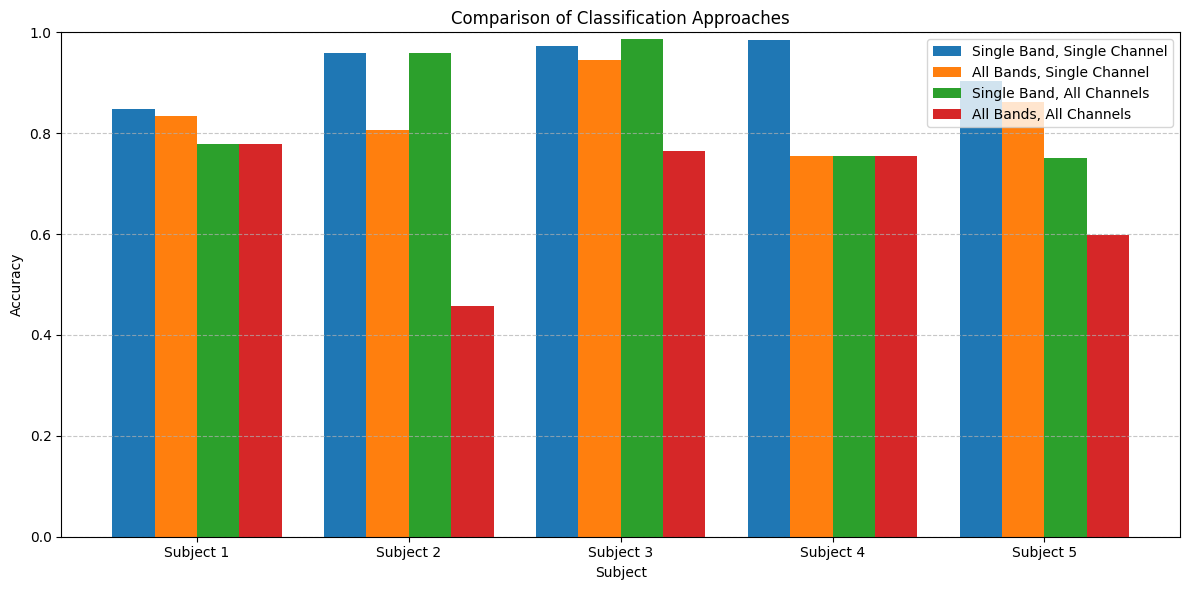

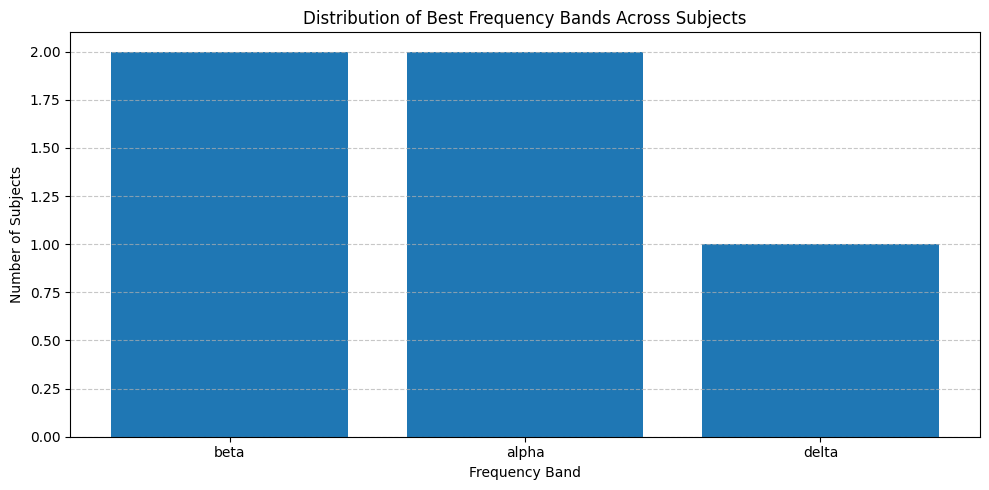

In [12]:
# Visualization of results

# Convert results to DataFrames for easier visualization
df_sb_sc = pd.DataFrame(all_sb_sc_results, columns=['Subject', 'Channel', 'Band', 'K', 'Accuracy'])
df_ab_sc = pd.DataFrame(all_ab_sc_results, columns=['Subject', 'Channel', 'K', 'Accuracy'])
df_sb_ac = pd.DataFrame(all_sb_ac_results, columns=['Subject', 'Band', 'K', 'Accuracy'])
df_ab_ac = pd.DataFrame(all_ab_ac_results, columns=['Subject', 'K', 'Accuracy'])

# Plot comparison of approaches for each subject
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(5)  # 5 subjects

# Extract accuracies for each approach
sb_sc_acc = df_sb_sc['Accuracy'].values
ab_sc_acc = df_ab_sc['Accuracy'].values
sb_ac_acc = df_sb_ac['Accuracy'].values
ab_ac_acc = df_ab_ac['Accuracy'].values

# Create bars
plt.bar(index, sb_sc_acc, bar_width, label='Single Band, Single Channel')
plt.bar(index + bar_width, ab_sc_acc, bar_width, label='All Bands, Single Channel')
plt.bar(index + 2*bar_width, sb_ac_acc, bar_width, label='Single Band, All Channels')
plt.bar(index + 3*bar_width, ab_ac_acc, bar_width, label='All Bands, All Channels')

# Customize plot
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Approaches')
plt.xticks(index + 1.5*bar_width, ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)  # Assuming accuracy ranges from 0.5 to 1.0

plt.tight_layout()
plt.show()

# Plot best frequency band distribution
plt.figure(figsize=(10, 5))

# Count occurrences of each band as the best
band_counts = df_sb_sc['Band'].value_counts()

plt.bar(band_counts.index, band_counts.values)
plt.title('Distribution of Best Frequency Bands Across Subjects')
plt.xlabel('Frequency Band')
plt.ylabel('Number of Subjects')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()